Coding up mass-radius-eccentricty hierarhcial Bayesian model in PyStan.

In [27]:
#'''
import numpy as np
import pandas as pd
import pystan
import stan_utility_copy
import pickle
import matplotlib.pyplot as plt
#'''
from pystan import StanModel
from __future__ import division, print_function
from pandas.tools.plotting import *
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20
#plt.style.use('ggplot')

import os
import requests
from cStringIO import StringIO
import generate_mre_ICs



%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#%qtconsole


In [2]:
# load data from input files
# TTV amplitudes
inputdata1 = "../data/input/TTVamplitudes.twos.t2.ready.for.jags.3_NAamps_posreal_uncs2.0_No_NaN_no1270.txt"
fx1 = open(inputdata1,'r')
datax1 = fx1.read()    
# Get column names
firstlinex1 = datax1.split('\n', 1)[0].split(' ')
firstlinex1 = [w.replace('"', '') for w in firstlinex1]
firstlinex1 = [w.replace('.', '_') for w in firstlinex1]
#print('firstlinex1', firstlinex1)
fx1.close()
# organize data from each file name in list
datax1 = np.genfromtxt(inputdata1, dtype=None, skip_header=1,names=firstlinex1 )

df_amp = pd.read_csv(inputdata1, delimiter=r"\s+")

df_amp


,KOI,P.int,P.ext,j,Delta,f,g,Re.V.int,sig.Re.V.int,Im.V.int,sig.Im.V.int,Re.V.ext,sig.Re.V.ext,Im.V.ext,si.Im.V.ext
0,222,6.312504,12.794594,2,0.013433,-1.160448,0.412684,0.001472,0.000422,0.000483,0.000415,-0.001392,0.001294,-0.003438,0.001134
1,238,17.232290,26.693760,3,0.032703,-1.821913,2.291051,-0.001170,0.001265,-0.001555,0.001149,-0.006047,0.005246,-0.002784,0.004987
2,244,6.238559,12.720365,2,0.019495,-1.147110,0.405590,0.001997,0.000225,0.001780,0.000202,0.000966,0.000110,0.000642,0.000084
3,251,4.164388,5.774470,4,0.039973,-2.352324,2.807316,0.000126,0.000239,0.000234,0.000255,0.000000,0.002243,0.003847,0.002304
4,255,13.603303,27.521732,2,0.011583,-1.164518,0.414848,0.000872,0.006073,0.004199,0.004940,0.001439,0.000876,-0.001108,0.000715
5,274,15.092050,22.795190,3,0.006940,-1.981901,2.443052,0.035334,0.004327,-0.024199,0.003559,0.031026,0.005247,-0.020840,0.005425
6,283,16.091941,25.517040,3,0.057135,-1.670189,2.146901,-0.000323,0.000358,0.000266,0.000366,-0.000496,0.004182,0.000714,0.003551
7,295,5.317435,10.105745,2,-0.049754,-1.299458,0.486612,-0.000991,0.000615,-0.000014,0.000578,-0.001085,0.001914,0.001170,0.001860
8,301,6.002551,11.448830,2,-0.046336,-1.291940,0.482613,0.000958,0.000961,-0.000960,0.000956,0.001593,0.003092,0.003337,0.003382
9,304,5.518350,8.512050,3,0.028333,-1.849054,2.316837,-0.001769,0.005168,0.002941,0.005452,-0.000081,0.000352,0.000422,0.000351


In [3]:
# Outer planet pair data
inputdata2 = "../data/input/Planet_and_Star_data_from_Q1_to_Q12_period_sorting_Pouter_2_sorted_No_NaN_no1270.txt"
fx2 = open(inputdata2,'r')
datax2 = fx2.read()    
# Get column names
firstlinex2 = datax2.split('\n', 1)[0].split(' ')
firstlinex2 = [w.replace('"', '') for w in firstlinex2]
firstlinex2 = [w.replace('.', '_') for w in firstlinex2]
#print('firstlinex2', firstlinex2)
fx2.close()
# organize data from each file name in list
datax2 = np.genfromtxt(inputdata2, dtype='float', skip_header=2,names=firstlinex2 )
datax2_s = np.genfromtxt(inputdata2, dtype=None, skip_header=2,names=firstlinex2 )

df_pouter = pd.read_csv(inputdata2, delimiter=r"\s+")

df_pouter


,rowid,kepid,kepoi.Name,koi.period,koi.period.err1,koi.period.err2,koi.duration,koi.duration.err1,koi.duration.err2,koi.depth,...,koi.steff.err2,koi.slogg,koi.slogg.err1,koi.slogg.err2,koi.srad,koi.srad.err1,koi.srad.err2,koi.smass,koi.smass.err1,koi.smass.err2
0,257,4249725,K00222.02,12.794551,0.000027,-0.000027,3.40510,0.05160,-0.05160,870.0,...,-187.0,4.697,0.095,-0.095,0.570,0.090,-0.090,0.590,0.090,-0.090
1,278,7219825,K00238.02,26.695166,0.000263,-0.000263,4.50500,0.22000,-0.22000,141.3,...,-124.0,4.367,0.077,-0.134,1.092,0.184,-0.099,1.012,0.063,-0.058
2,287,4349452,K00244.01,12.720374,0.000002,-0.000002,2.59373,0.00729,-0.00729,1176.3,...,-79.0,4.279,0.009,-0.009,1.309,0.023,-0.023,1.187,0.060,-0.060
3,306,10489206,K00251.02,5.774422,0.000029,-0.000029,1.81900,0.11900,-0.11900,265.3,...,-65.0,4.738,0.070,-0.070,0.520,0.060,-0.060,0.540,0.060,-0.060
4,311,7021681,K00255.01,27.521980,0.000033,-0.000033,4.07040,0.03890,-0.03890,2500.8,...,-78.0,4.747,0.071,-0.071,0.510,0.060,-0.060,0.530,0.060,-0.060
5,338,8077137,K00274.02,22.802981,0.000108,-0.000108,4.99160,0.09860,-0.09860,66.4,...,-75.0,4.070,0.011,-0.011,1.659,0.038,-0.038,1.184,0.074,-0.074
6,353,5695396,K00283.02,25.517065,0.000196,-0.000196,5.14100,0.17400,-0.17400,63.1,...,-133.0,4.505,0.022,-0.143,0.958,0.163,-0.043,1.071,0.049,-0.083
7,373,11547513,K00295.02,10.105753,0.000032,-0.000032,2.01900,0.08610,-0.08610,111.6,...,-231.0,4.167,0.202,-0.292,1.533,0.796,-0.416,1.263,0.235,-0.247
8,381,3642289,K00301.02,11.448595,0.000081,-0.000081,4.91100,0.14300,-0.14300,76.0,...,-225.0,4.349,0.076,-0.394,1.209,0.891,-0.159,1.187,0.297,-0.170
9,385,6029239,K00304.01,8.512036,0.000004,-0.000004,2.19160,0.01580,-0.01580,573.8,...,-179.0,3.985,0.326,-0.196,1.825,0.720,-0.671,1.173,0.299,-0.201


In [4]:
# Inner planet pair data
inputdata3 = "../data/input/Planet_and_Star_data_from_Q1_to_Q12_period_sorting_Pinner_2_sorted_No_NaN_no1270.txt" 
fx3 = open(inputdata2,'r')
datax3 = fx3.read()    
# Get column names
firstlinex3 = datax3.split('\n', 1)[0].split(' ')
firstlinex3 = [w.replace('"', '') for w in firstlinex3]
firstlinex3 = [w.replace('.', '_') for w in firstlinex3]
#print(firstlinex3)
fx3.close()
# organize data from each file name in list
datax3 = np.genfromtxt(inputdata3, dtype='float', skip_header=3,names=firstlinex3 )
datax3_s = np.genfromtxt(inputdata3, dtype=None, skip_header=3,names=firstlinex3 )

df_pinner = pd.read_csv(inputdata3, delimiter=r"\s+")

df_pinner

,rowid,kepid,kepoi.Name,koi.period,koi.period.err1,koi.period.err2,koi.duration,koi.duration.err1,koi.duration.err2,koi.depth,...,koi.steff.err2,koi.slogg,koi.slogg.err1,koi.slogg.err2,koi.srad,koi.srad.err1,koi.srad.err2,koi.smass,koi.smass.err1,koi.smass.err2
0,256,4249725,K00222.01,6.312504,0.000005,-0.000005,2.74760,0.0264,-0.0264,1371.3,...,-187.0,4.697,0.095,-0.095,0.570,0.090,-0.090,0.590,0.090,-0.090
1,277,7219825,K00238.01,17.232317,0.000036,-0.000036,4.53180,0.0539,-0.0539,522.3,...,-124.0,4.367,0.077,-0.134,1.092,0.184,-0.099,1.012,0.063,-0.058
2,288,4349452,K00244.02,6.238535,0.000002,-0.000002,3.54393,0.0089,-0.0089,402.8,...,-79.0,4.279,0.009,-0.009,1.309,0.023,-0.023,1.187,0.060,-0.060
3,305,10489206,K00251.01,4.164384,0.000002,-0.000002,1.84280,0.0233,-0.0233,2529.1,...,-65.0,4.738,0.070,-0.070,0.520,0.060,-0.060,0.540,0.060,-0.060
4,312,7021681,K00255.02,13.603082,0.000185,-0.000185,2.52100,0.3380,-0.3380,173.8,...,-78.0,4.747,0.071,-0.071,0.510,0.060,-0.060,0.530,0.060,-0.060
5,337,8077137,K00274.01,15.089602,0.000044,-0.000044,4.21080,0.0650,-0.0650,74.2,...,-75.0,4.070,0.011,-0.011,1.659,0.038,-0.038,1.184,0.074,-0.074
6,352,5695396,K00283.01,16.091972,0.000011,-0.000011,2.87900,0.0177,-0.0177,435.4,...,-133.0,4.505,0.022,-0.143,0.958,0.163,-0.043,1.071,0.049,-0.083
7,372,11547513,K00295.01,5.317435,0.000005,-0.000005,2.88750,0.0257,-0.0257,284.2,...,-231.0,4.167,0.202,-0.292,1.533,0.796,-0.416,1.263,0.235,-0.247
8,380,3642289,K00301.01,6.002536,0.000009,-0.000009,3.90880,0.0369,-0.0369,200.8,...,-225.0,4.349,0.076,-0.394,1.209,0.891,-0.159,1.187,0.297,-0.170
9,386,6029239,K00304.02,5.518171,0.000072,-0.000072,2.32000,0.2840,-0.2840,28.9,...,-179.0,3.985,0.326,-0.196,1.825,0.720,-0.671,1.173,0.299,-0.201


In [5]:
print(np.hstack(( df_amp.loc[[0], "KOI"].reshape(-1,1), df_pouter.loc[[0], "kepoi.Name"].reshape(-1,1), df_pinner.loc[[0] , "kepoi.Name"].reshape(-1,1)) ))
print(np.hstack(( df_amp.loc[[1], "KOI"].reshape(-1,1), df_pouter.loc[[1], "kepoi.Name"].reshape(-1,1), df_pinner.loc[[1] , "kepoi.Name"].reshape(-1,1)) ))
print(np.hstack(( df_amp.loc[[2], "KOI"].reshape(-1,1), df_pouter.loc[[2], "kepoi.Name"].reshape(-1,1), df_pinner.loc[[2] , "kepoi.Name"].reshape(-1,1)) ))
print(np.hstack(( df_amp.loc[[3], "KOI"].reshape(-1,1), df_pouter.loc[[3], "kepoi.Name"].reshape(-1,1), df_pinner.loc[[3] , "kepoi.Name"].reshape(-1,1)) ))
print(np.hstack(( df_amp.loc[[4], "KOI"].reshape(-1,1), df_pouter.loc[[4], "kepoi.Name"].reshape(-1,1), df_pinner.loc[[4] , "kepoi.Name"].reshape(-1,1)) ))
print(np.hstack(( df_amp.loc[[98], "KOI"].reshape(-1,1), df_pouter.loc[[98], "kepoi.Name"].reshape(-1,1), df_pinner.loc[[98] , "kepoi.Name"].reshape(-1,1)) ))

[[222 'K00222.02' 'K00222.01']]
[[238 'K00238.02' 'K00238.01']]
[[244 'K00244.01' 'K00244.02']]
[[251 'K00251.02' 'K00251.01']]
[[255 'K00255.01' 'K00255.02']]
[[4504 'K04504.02' 'K04504.01']]


In [6]:
#print(np.hstack(( df_amp.loc[:, "KOI"].reshape(-1,1), df_pouter.loc[:, "kepoi.Name"].reshape(-1,1), df_pinner.loc[: , "kepoi.Name"].reshape(-1,1)) ))

In [7]:
Ndata = len( df_amp.loc[:, "KOI"] )

print(Ndata, len( df_pouter.loc[:, "kepoi.Name"] ), len( df_pinner.loc[:, "kepoi.Name"]) )

#print(np.hstack(( df_amp.loc[:, "KOI"].reshape(-1,1), df_pouter.loc[:, "kepoi.Name"].reshape(-1,1), df_pinner.loc[:, "kepoi.Name"].reshape(-1,1) )))

Nm = 2

###TTV amp data:
P_ext = df_pouter.loc[:, "koi.period"]
P_int = df_pinner.loc[:, "koi.period"]
j = df_amp.loc[:, "j"]
g = df_amp.loc[:, "g"]
f = df_amp.loc[:, "f"]
delta = df_amp.loc[:, "Delta"]
print( 'delta', delta )

m_sun = 332996.4274 #Msun in Mearth units
r_sun = 110.0
min_radius_s = 0.5 * r_sun #put priors over this
max_radius_s = 2.0 * r_sun  #put priors over this
min_mass_s = 0.8 * m_sun
max_mass_s = 3.0 * m_sun
####

    
sigma_radius_s_obs = r_sun * ( ( df_pinner.loc[:, "koi.srad.err1"] + abs( df_pinner.loc[:, "koi.srad.err2"] ) ) / 2.0 )
sigma_mass_s_obs = m_sun * ( ( df_pinner.loc[:, "koi.smass.err1"] + abs( df_pinner.loc[:, "koi.smass.err2"] ) ) / 2.0 )
sigma_radius_ratio_obs_int = ( df_pinner.loc[:, "koi.ror.err1"] + abs(df_pinner.loc[:, "koi.ror.err2"] ) ) / 2.0
sigma_radius_ratio_obs_ext = ( df_pouter.loc[:, "koi.ror.err1"] + abs(df_pouter.loc[:, "koi.ror.err2"] ) ) / 2.0
print('sigma.radius.ratio.obs.ext', sigma_radius_ratio_obs_ext)
print('sigma.radius.s.obs', sigma_radius_s_obs)
print('sigma.mass.s.obs', sigma_mass_s_obs)

sigma_va_obs_int = df_amp.loc[:, "sig.Re.V.int"] 
sigma_vb_obs_int = df_amp.loc[:, "sig.Im.V.int"] 
sigma_va_obs_ext = df_amp.loc[:, "sig.Re.V.ext"] 
sigma_vb_obs_ext = df_amp.loc[:, "si.Im.V.ext"] 

va_obs_int = df_amp.loc[:, "Re.V.int"]
va_obs_ext = df_amp.loc[:, "Re.V.ext"]
vb_obs_int = df_amp.loc[:, "Im.V.int"]
vb_obs_ext = df_amp.loc[:, "Im.V.ext"]

print('radius.s.obs', df_pinner.loc[:, "koi.srad"] )
print('radius.s.obs', r_sun * ( df_pinner.loc[:, "koi.srad"] ))
print('va.obs.int', va_obs_int)

radius_ratio_obs_int = df_pouter.loc[:, "koi.ror"]
radius_ratio_obs_ext = df_pinner.loc[:, "koi.ror"]
radius_s_obs = r_sun * ( df_pinner.loc[:, "koi.srad"] )
mass_s_obs = m_sun * ( df_pinner.loc[:, "koi.smass"] )

print('radius.s.obs', radius_s_obs)
print('mass.s.obs', mass_s_obs)


99 99 99
delta 0     0.013433
1     0.032703
2     0.019495
3     0.039973
4     0.011583
5     0.006940
6     0.057135
7    -0.049754
8    -0.046336
9     0.028333
10   -0.055802
11   -0.047238
12    0.006397
13    0.081477
14   -0.065754
15    0.080143
16   -0.006210
17   -0.043046
18    0.050735
19    0.005550
20    0.028290
21    0.052535
22    0.022942
23   -0.043795
24    0.077180
25   -0.031980
26   -0.068568
27   -0.036310
28   -0.091627
29   -0.069504
        ...   
69    0.079805
70   -0.087062
71   -0.029455
72    0.003320
73   -0.047336
74    0.071325
75    0.023297
76   -0.011543
77    0.060972
78    0.094626
79    0.029486
80    0.082225
81    0.088245
82   -0.039218
83   -0.050347
84   -0.002380
85    0.011906
86   -0.010506
87   -0.085362
88    0.027432
89   -0.077312
90    0.040666
91    0.022095
92   -0.055976
93   -0.022014
94    0.062859
95    0.027112
96   -0.035885
97    0.013521
98   -0.017136
Name: Delta, dtype: float64
sigma.radius.ratio.obs.ext 0     0.000630


In [8]:
df_pouter.columns

Index([u'rowid', u'kepid', u'kepoi.Name', u'koi.period', u'koi.period.err1',
       u'koi.period.err2', u'koi.duration', u'koi.duration.err1',
       u'koi.duration.err2', u'koi.depth', u'koi.depth.err1',
       u'koi.depth.err2', u'koi.ror', u'koi.ror.err1', u'koi.ror.err2',
       u'koi.srho', u'koi.srho.err1', u'koi.srho.err2', u'koi.prad',
       u'koi.prad.err1', u'koi.prad.err2', u'koi.insol', u'koi.insol.err1',
       u'koi.insol.err2', u'koi.steff', u'koi.steff.err1', u'koi.steff.err2',
       u'koi.slogg', u'koi.slogg.err1', u'koi.slogg.err2', u'koi.srad',
       u'koi.srad.err1', u'koi.srad.err2', u'koi.smass', u'koi.smass.err1',
       u'koi.smass.err2'],
      dtype='object')

In [9]:
df_amp.columns

Index([u'KOI', u'P.int', u'P.ext', u'j', u'Delta', u'f', u'g', u'Re.V.int',
       u'sig.Re.V.int', u'Im.V.int', u'sig.Im.V.int', u'Re.V.ext',
       u'sig.Re.V.ext', u'Im.V.ext', u'si.Im.V.ext'],
      dtype='object')

In [10]:
%%time
!date


mass_radius_powerlaw_model = """

data {    
    
    //Constants:
    int<lower=1> Nm;
    int<lower=1> Ndata;
    real P_ext[Ndata]; 
    real P_int[Ndata];
    real j[Ndata];
    real g[Ndata];
    real fc[Ndata]; 
    real delta[Ndata]; 

    // Observations: 
    real radius_ratio_obs_int[Ndata];
    real radius_ratio_obs_ext[Ndata];
    real va_obs_int[Ndata];
    real va_obs_ext[Ndata];
    real vb_obs_int[Ndata];
    real vb_obs_ext[Ndata];
    real sigma_va_obs_int[Ndata];
    real sigma_vb_obs_int[Ndata];
    real sigma_va_obs_ext[Ndata];
    real sigma_vb_obs_ext[Ndata]; 
    real sigma_radius_s[Ndata];
    real sigma_mass_s[Ndata];
    real sigma_radius_ratio_obs_int[Ndata];
    real sigma_radius_ratio_obs_ext[Ndata];
    real radius_s_obs[Ndata];
    real mass_s_obs[Ndata];
    
}


parameters {

    // eccentricity distribution hyperparameters:
    simplex[Nm] f;
    real<lower>=0> e_sigma[Nm];

    // mass-radius distribution hyperparameters:
     real<lower=-3.0, upper=3.0> mass_const;
     real<lower=0.0> mass_radius_exp;
     real<lower=0.01, upper=10.0> sigma_mass_radius; 
    //real<lower=-10.0, upper=10.0> beta; 
    //real mass_const;
    //real mass_radius_exp;
    //real sigma_mass_radius; 
    
    // eccentricity distribution latent variables:
    // -sqrt(1-(h_true_int[i]*h_true_int[i])),sqrt(1-(h_true_int[i]*h_true_int[i]))
    real<lower=-1,upper=1> h_int[Ndata];
    real<lower=-1,upper=1> k_int[Ndata];
    real<lower=-1,upper=1> h_ext[Ndata];
    real<lower=-1,upper=1> k_ext[Ndata];
    
    // mass-radius distribution latent variables:
    real<lower=0> radius_p_true_int[Ndata]; 
    real<lower=0> mass_p_true_int[Ndata];
    real<lower=0> radius_p_true_ext[Ndata]; 
    real<lower=0> mass_p_true_ext[Ndata];
    
    // True params for observed variables
    real va_true_int[Ndata];
    real vb_true_int[Ndata];   
    real va_true_ext[Ndata];
    real vb_true_ext[Ndata];
    real radius_ratio_true_int[Ndata]; 
    real radius_ratio_true_ext[Ndata]; 
    real<lower=0> mass_s_true[Ndata];
    real<lower=0> radius_s_true[Ndata];

}

model { 

    // Constants
    real m_sun;
    real r_sun;
    real min_radius_s;
    real max_radius_s;
    real min_mass_s;
    real max_mass_s;
    real min_radius_p_inner;
    real max_radius_p_inner;
    real min_radius_p_outer;
    real max_radius_p_outer;

    //real C1[Ndata];
    //real C2[Ndata];
    //real C3[Ndata];
    
    //Quantities I care about:
    //real mass_ratio_true_int[Ndata];
    //real mass_ratio_true_ext[Ndata];
    //real mass_ref_int[Ndata];
    //real mass_ref_ext[Ndata];

    

    r_sun = 110.0;  // Rsun in Rearth units
    m_sun = 332996.4274; // Msun in Mearth units

    min_radius_s = 0.1 * r_sun; // put priors over this
    max_radius_s = 5.34 * r_sun; // put priors over this
        
    min_mass_s = 0.05 * m_sun; // put priors over this
    max_mass_s = 2.4 * m_sun;  // put priors over this
    
    // radius_p_exp ~ uniform(0.0,2.0);

    // radius_s_true = r_sun;
    // mass_s_true = m_sun;

    min_radius_p_inner = 0.1;
    max_radius_p_inner = 15.0;
    min_radius_p_outer = 0.1;
    max_radius_p_outer = 15.0;

    // eccentricity distribution model section (generalized for interior/exterior pairs):
    
     e_sigma[1] ~ uniform(0.0, 1.0);
     e_sigma[2] ~ uniform(0.0, 1.0);

    // interior planet eccentricty:
    
    h_int ~ uniform(0.0,1.0);
    k_int ~ uniform(0.0,1.0);

    for (n in 1:Ndata)
      target += log_mix(f[1], normal_lpdf(h_int[n] | 0.0, e_sigma[1]), normal_lpdf(h_int[n] | 0.0, e_sigma[2]));
    for (n in 1:Ndata)
      target += log_mix(f[1], normal_lpdf(k_int[n] | 0.0, e_sigma[1]), normal_lpdf(k_int[n] | 0.0, e_sigma[2]));
      
      
    //exterior planet eccentricity:
    
    h_ext ~ uniform(0.0,1.0);
    k_ext ~ uniform(0.0,1.0);

    for (n in 1:Ndata)
      target += log_mix(f[1], normal_lpdf(h_ext[n] | 0.0, e_sigma[1]), normal_lpdf(h_ext[n] | 0.0, e_sigma[2]));
    for (n in 1:Ndata)
      target += log_mix(f[1], normal_lpdf(k_ext[n] | 0.0, e_sigma[1]), normal_lpdf(k_ext[n] | 0.0, e_sigma[2]));


    // mass-radius distribution model section:
    
     mass_const ~ uniform(-3,3);
    
     mass_radius_exp ~ normal(1.0,1.0);
    
     sigma_mass_radius ~ uniform(0.01,10.0); 
    
    // mass_const ~ normal(1,1);
    
    // mass_radius_exp ~ normal(1,1);

    // sigma_mass_radius ~ normal(1,1); 

    // mass_const ~ gamma(1,1);
    
    // mass_radius_exp ~ gamma(1,1);

    // sigma_mass_radius ~ gamma(1,1); 
   
    
    for (i in 1:Ndata) {        

        radius_s_true[i] ~ uniform( min_radius_s, max_radius_s );
        
        radius_s_obs[i] ~ normal( radius_s_true[i], sigma_radius_s[i] ) T[0,]; 


        mass_s_true[i] ~ uniform( min_mass_s, max_mass_s );
        
        mass_s_obs[i] ~ normal( mass_s_true[i], sigma_mass_s[i] ) T[0,];

        
        radius_p_true_int[i] ~ uniform( min_radius_p_inner, max_radius_p_inner ); 
        
        
        //radius_ratio_true_int[i] = radius_p_true_int[i] / radius_s_true[i];
        
        //radius_ratio_obs_int[i] ~ normal( radius_ratio_true_int[i], sigma_radius_ratio_obs_int[i] ) T[0,];
        
        radius_ratio_obs_int[i] ~ normal( (radius_p_true_int[i] / radius_s_true[i]), sigma_radius_ratio_obs_int[i] ) T[0,];


        //mass_ref_int[i] = (mass_radius_exp * log(radius_p_true_int[i])) + mass_const;
        
        //mass_p_true_int[i] ~ normal( mass_ref_int[i], sigma_mass_radius ) T[0,];
        
        mass_p_true_int[i] ~ normal( ((mass_radius_exp * log(radius_p_true_int[i])) + mass_const), sigma_mass_radius ) T[0,];


        radius_p_true_ext[i] ~ uniform( min_radius_p_outer, max_radius_p_outer ); 


        //radius_ratio_true_ext[i] = radius_p_true_ext[i] / radius_s_true[i];

        //radius_ratio_obs_ext[i] ~ normal( radius_ratio_true_ext[i], sigma_radius_ratio_obs_ext[i] ) T[0,]; 

        radius_ratio_obs_ext[i] ~ normal( (radius_p_true_ext[i] / radius_s_true[i]), sigma_radius_ratio_obs_ext[i] ) T[0,]; 

        
        //mass_ref_ext[i] = (mass_radius_exp * log(radius_p_true_ext[i])) + mass_const;

        //mass_p_true_ext[i] ~ normal( mass_ref_ext[i], sigma_mass_radius ) T[0,];
        
        mass_p_true_ext[i] ~ normal( ((mass_radius_exp * log(radius_p_true_ext[i])) + mass_const), sigma_mass_radius ) T[0,];


        //mass_ratio_true_int[i] = mass_p_true_int[i] / mass_s_true[i];  
        
        //mass_ratio_true_ext[i] = mass_p_true_ext[i] / mass_s_true[i];  



        //C1[i] = (P_int[i] / ( ( pi() * ( j[i]^(2./3.) ) * ( (j[i]-1.0)^(1./3.) * delta[i] ) ) ));
        //C2[i] = (3.0 / ( 2.0 * delta[i] ));
        //C3[i] = (P_ext[i] / ( pi() * j[i] * delta[i] ));

        //va_true_int[i] = ( ( (-1.0) * C1[i] * mass_ratio_true_ext[i] * fc[i] ) - ( ( C1[i] * C2[i] * mass_ratio_true_ext[i] ) * ( ( fc[i] * h_int[i] ) + ( g[i] * h_ext[i] ) ) ) );

        //vb_true_int[i] = ( ( C1[i] * C2[i] * mass_ratio_true_ext[i] ) * ( ( fc[i] * k_int[i] ) + ( g[i] * k_ext[i] ) ) );

        //va_true_ext[i] = ( ( (-1.0) * C3[i] * mass_ratio_true_int[i] * g[i] ) + ( ( C2[i] * C3[i] * mass_ratio_true_int[i] ) * ( ( fc[i] * h_int[i] ) + ( g[i] * h_ext[i] ) ) ) );

        //vb_true_ext[i] = ( ( (-1.0) * C2[i] * C3[i] * mass_ratio_true_int[i] ) * ( ( fc[i] * k_int[i] ) + ( g[i] * k_ext[i] ) ) );

        
        //va_true_int[i] = ( ( (-1.0) * (P_int[i] / ( ( pi() * ( j[i]^(2./3.) ) * ( (j[i]-1.0)^(1./3.) * delta[i] ) ) )) * (mass_p_true_ext[i] / mass_s_true[i]) * fc[i] ) - ( ( (P_int[i] / ( ( pi() * ( j[i]^(2./3.) ) * ( (j[i]-1.0)^(1./3.) * delta[i] ) ) )) * (3.0 / ( 2.0 * delta[i] )) * (mass_p_true_ext[i] / mass_s_true[i]) ) * ( ( fc[i] * h_int[i] ) + ( g[i] * h_ext[i] ) ) ) );

        //vb_true_int[i] = ( ( (P_int[i] / ( ( pi() * ( j[i]^(2./3.) ) * ( (j[i]-1.0)^(1./3.) * delta[i] ) ) )) * (3.0 / ( 2.0 * delta[i] )) * (mass_p_true_ext[i] / mass_s_true[i]) ) * ( ( fc[i] * k_int[i] ) + ( g[i] * k_ext[i] ) ) );

        //va_true_ext[i] = ( ( (-1.0) * (P_ext[i] / ( pi() * j[i] * delta[i] )) * (mass_p_true_int[i] / mass_s_true[i]) * g[i] ) + ( ( (3.0 / ( 2.0 * delta[i] )) * (P_ext[i] / ( pi() * j[i] * delta[i] )) * (mass_p_true_int[i] / mass_s_true[i]) ) * ( ( fc[i] * h_int[i] ) + ( g[i] * h_ext[i] ) ) ) );

        //vb_true_ext[i] = ( ( (-1.0) * (3.0 / ( 2.0 * delta[i] )) * (P_ext[i] / ( pi() * j[i] * delta[i] )) * (mass_p_true_int[i] / mass_s_true[i]) ) * ( ( fc[i] * k_int[i] ) + ( g[i] * k_ext[i] ) ) );
        

        //va_obs_int[i] ~ normal( va_true_int[i], sigma_va_obs_int[i] );
        
        //vb_obs_int[i] ~ normal( vb_true_int[i], sigma_vb_obs_int[i] );   

        //va_obs_ext[i] ~ normal( va_true_ext[i], sigma_va_obs_ext[i] );
        
        //vb_obs_ext[i] ~ normal( vb_true_ext[i], sigma_vb_obs_ext[i] ); 
                
        
        va_obs_int[i] ~ normal( ( ( (-1.0) * (P_int[i] / ( ( pi() * ( j[i]^(2./3.) ) * ( (j[i]-1.0)^(1./3.) * delta[i] ) ) )) * (mass_p_true_ext[i] / mass_s_true[i]) * fc[i] ) - ( ( (P_int[i] / ( ( pi() * ( j[i]^(2./3.) ) * ( (j[i]-1.0)^(1./3.) * delta[i] ) ) )) * (3.0 / ( 2.0 * delta[i] )) * (mass_p_true_ext[i] / mass_s_true[i]) ) * ( ( fc[i] * h_int[i] ) + ( g[i] * h_ext[i] ) ) ) ), sigma_va_obs_int[i] );
        
        vb_obs_int[i] ~ normal( ( ( (P_int[i] / ( ( pi() * ( j[i]^(2./3.) ) * ( (j[i]-1.0)^(1./3.) * delta[i] ) ) )) * (3.0 / ( 2.0 * delta[i] )) * (mass_p_true_ext[i] / mass_s_true[i]) ) * ( ( fc[i] * k_int[i] ) + ( g[i] * k_ext[i] ) ) ), sigma_vb_obs_int[i] );   

        va_obs_ext[i] ~ normal( ( ( (-1.0) * (P_ext[i] / ( pi() * j[i] * delta[i] )) * (mass_p_true_int[i] / mass_s_true[i]) * g[i] ) + ( ( (3.0 / ( 2.0 * delta[i] )) * (P_ext[i] / ( pi() * j[i] * delta[i] )) * (mass_p_true_int[i] / mass_s_true[i]) ) * ( ( fc[i] * h_int[i] ) + ( g[i] * h_ext[i] ) ) ) ), sigma_va_obs_ext[i] );
        
        vb_obs_ext[i] ~ normal( ( ( (-1.0) * (3.0 / ( 2.0 * delta[i] )) * (P_ext[i] / ( pi() * j[i] * delta[i] )) * (mass_p_true_int[i] / mass_s_true[i]) ) * ( ( fc[i] * k_int[i] ) + ( g[i] * k_ext[i] ) ) ), sigma_vb_obs_ext[i] ); 


    }

}

"""


sm = StanModel(model_code=mass_radius_powerlaw_model)


!date

Thu Jan 25 16:52:40 PST 2018
Thu Jan 25 16:53:32 PST 2018
CPU times: user 1.63 s, sys: 316 ms, total: 1.95 s
Wall time: 52 s


In [11]:
data = {'P_ext':P_ext, 'P_int':P_int, 'j':j, 'g':g, 'fc':f, 'delta':delta, 
        'radius_ratio_obs_int':radius_ratio_obs_int, 'radius_ratio_obs_ext':radius_ratio_obs_ext,
        'va_obs_int':va_obs_int, 'va_obs_ext':va_obs_ext, 'vb_obs_int':vb_obs_int,
        'vb_obs_ext':vb_obs_ext, 'sigma_va_obs_int':sigma_va_obs_int,
        'sigma_vb_obs_int':sigma_vb_obs_int, 'sigma_va_obs_ext':sigma_va_obs_ext,
        'sigma_vb_obs_ext':sigma_vb_obs_ext, 'sigma_radius_s':sigma_radius_s_obs,
        'sigma_mass_s':sigma_mass_s_obs, 'sigma_radius_ratio_obs_int':sigma_radius_ratio_obs_int, 
        'sigma_radius_ratio_obs_ext':sigma_radius_ratio_obs_ext, 'radius_s_obs':radius_s_obs, 
        'mass_s_obs':mass_s_obs, 'Ndata':Ndata, 'Nm':Nm}

type(data)


dict

In [23]:
%%time
!date

nTotalPerChain = 1000
#nSamplesPerChain = int(round(nTotalPerChain/2))
nChains = 5

Stan_ICs = generate_mre_ICs.ICs_mre(data, nChains)

fit = sm.sampling(data=data, iter=nTotalPerChain, chains=nChains,  init=Stan_ICs, n_jobs=-1)
#fit = sm.sampling(data=data, iter=10, chains=2, init=init, n_jobs=-1)
#fit = pystan.stan(model_code=mass_radius_powerlaw_model, data=data, iter=1, chains=1, n_jobs=-1);


!date

Thu Jan 25 17:02:44 PST 2018
Thu Jan 25 17:19:45 PST 2018
CPU times: user 1.1 s, sys: 405 ms, total: 1.51 s
Wall time: 17min 1s


In [28]:
Stan_ICs = generate_mre_ICs.ICs_mre(data, nChains)
print(Stan_ICs[0].keys())

['va_true_ext', 'radius_ratio_true_ext', 'mass_s_true', 'h_int', 'vb_true_int', 'h_ext', 'radius_ratio_true_int', 'va_true_int', 'k_int', 'radius_s_true', 'vb_true_ext', 'k_ext']


Help on module stan_utility_copy:

NAME
    stan_utility_copy

FILE
    /Users/meganshabram/Dropbox/NASA_Postdoctoral_Program_Fellowship/MRE_PyStan/codes/stan_utility_copy.py

DESCRIPTION
    #Copyright 2017 Columbia University, 2017 Jeff Alstott
    #
    #Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:
    #
    #1. Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.
    #
    #2. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.
    #
    #3. Neither the name of the copyright holder nor the name INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIB

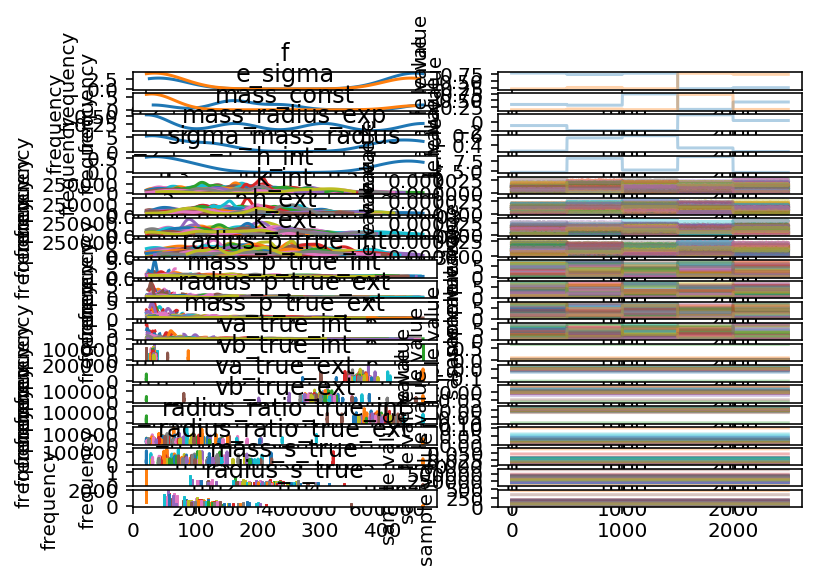

In [29]:
help(stan_utility_copy)
print(fit)
stan_utility_copy.check_treedepth(fit)
stan_utility_copy.check_energy(fit)
stan_utility_copy.check_div(fit)
fig = fit.traceplot()